# Code for loading in the datasets and modelling

In [1]:
from loader import list_files, Files, Folders  #precalculate what we are loading in
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sys import getsizeof

## Load in data

In [16]:
class loaded:
    def __init__(self):
        data = np.load("/its/home/drs25/Documents/data/Tactile Dataset/X_texture.npz") #load data
        for array_name in data:
            self.X=data[array_name].astype(np.int8)
        data = np.load("/its/home/drs25/Documents/data/Tactile Dataset/y_texture.npz") #load data
        for array_name in data:
            self.y=data[array_name].astype(np.int8)
        self.keys={}
        print("Dataset size:",self.X.shape[0],"\nWindow size:",self.X.shape[1],"\nImage:",self.X.shape[2:])
        print("Memory needed:",round(getsizeof(self.X)/ 1024 / 1024/ 1024,2),"GB")
        assert self.X.shape[0]==self.y.shape[0],"Incorrect data size match y="+str(self.y.shape[0])+" x="+str(self.X.shape[0])
        #randomize order
        """n_samples = self.X.shape[0]
        indices = np.random.permutation(n_samples)
        shuffled_data = self.X[indices]
        shuffled_labels = self.y[indices]
        self.X=shuffled_data
        self.y=shuffled_labels"""
    def applySobel(self):
        for i in range(len(self.X)): #crop all images individually
            for j in range(len(self.X[0])):
                image=self.X[i][j]
                # Apply Sobel filter in x-direction
                sobel_x = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=3)  # ksize=3 for a 3x3 Sobel kernel

                # Apply Sobel filter in y-direction
                sobel_y = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=3)

                # Convert the results back to uint8
                sobel_x = np.uint8(np.absolute(sobel_x))
                sobel_y = np.uint8(np.absolute(sobel_y))

                # Combine the results to get the final edge-detected image
                sobel_combined = cv2.bitwise_or(sobel_x, sobel_y)
                self.X[i][j]=sobel_combined
data=loaded()

Dataset size: 400 
Window size: 20 
Image: (110, 120)
Memory needed: 0.1 GB


In [265]:
data.applySobel()

AttributeError: 'loaded' object has no attribute 'keys'

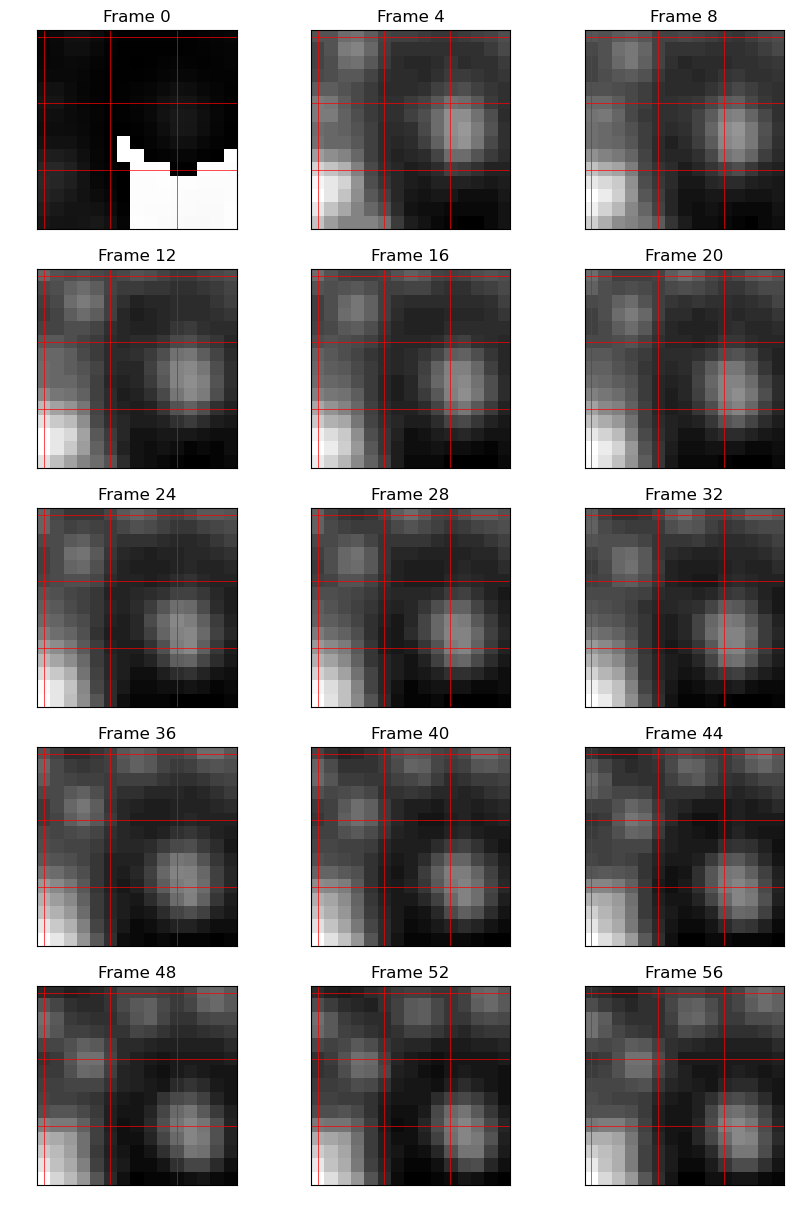

In [13]:
num_images = 15
texture=np.random.randint(0,100)
images = data.X[texture][0:15]

num_rows = 5
num_cols = 3
fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 15))

# Flatten the axes array for easy indexing
axes = axes.flatten()
ax = axes[0]
ax.set_title("Frame "+str(0))
ax.imshow(images[0][50:65,50:65], cmap='gray')
ax.set_xticks(np.arange(0, 15, 5))
# Set custom ticks for y-axis (every 10 units)
ax.set_yticks(np.arange(0, 15, 5))
ax.tick_params(axis='x', colors='white')
ax.tick_params(axis='y', colors='white')
ax.grid(True, which='both', axis='both', color='r', linestyle='-', linewidth=0.5)
# Plot each image
imageA=images[0].astype(np.uint8)
kernel=np.array((9,9))
for i in range(1,num_images):
    imageB=images[i].astype(np.uint8)
    imageB[imageB<20]=0

    ax = axes[i]
    ax.imshow(imageB[50:65,50:65],cmap="gray")
    #ax.axis('off')
    ax.set_xticks(np.arange(0, 15, 5))
    # Set custom ticks for y-axis (every 10 units)
    ax.set_yticks(np.arange(0, 15, 5))
    ax.tick_params(axis='x', colors='white')
    ax.tick_params(axis='y', colors='white')
    ax.grid(True, which='both', axis='both', color='r', linestyle='-', linewidth=0.5)
    ax.set_title("Frame "+str(i*4))
    

# Remove any empty subplots
for i in range(num_images, num_rows*num_cols):
    fig.delaxes(axes[i])
plt.suptitle("Flow of "+str(data.keys[data.y[texture]].split("_")[1]))
plt.tight_layout()
plt.savefig("/its/home/drs25/Pictures/TacTip real/rigData/centrepointMove.pdf")
plt.show()

## Look at spread of changes

In [306]:
#change=[np.zeros((len(data.X[0]))) for i in range(len(data.keys))]
change=np.zeros((7,41,len(data.X[0])))
counter=[0 for i in range(len(data.keys))]
for i in range(len(data.X)):
    y=data.y[i]
    framesA=data.X[i][0:-2].reshape(data.X[i].shape[0], -1)
    framesB=data.X[i][1:-1].reshape(data.X[i].shape[0], -1)
    difference=np.abs(np.sum(framesA-framesB,axis=1))
    change[y][counter[y]]=difference
    counter[y]+=1

change=(np.array(change).T/np.array(counter)).T
change.shape

(7, 41, 20)

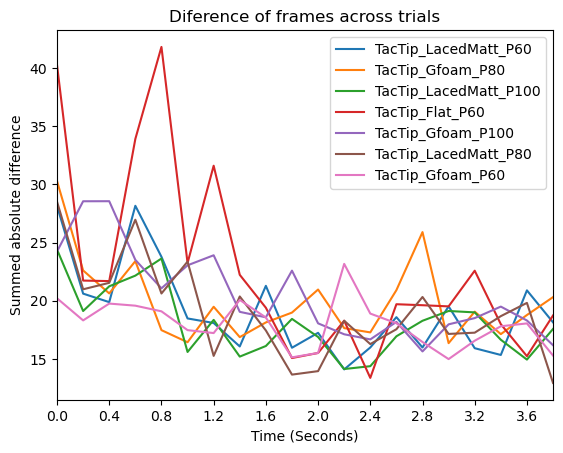

In [317]:
av=np.average(change,axis=1)
for i in range(len(change)):
    plt.plot(av[i],label=data.keys[i])

plt.legend(loc="upper right")
plt.xticks([i for i in range(0,len(change[2]),int(len(data.X[0])*0.1))], labels=[round((4/len(data.X[0]))*i,2) for i in range(0,len(change[2]),int(len(data.X[0])*0.1))])
plt.xlabel("Time (Seconds)")
plt.xlim([0,19])
plt.ylabel("Summed absolute difference")
plt.title("Diference of frames across trials")
plt.show()

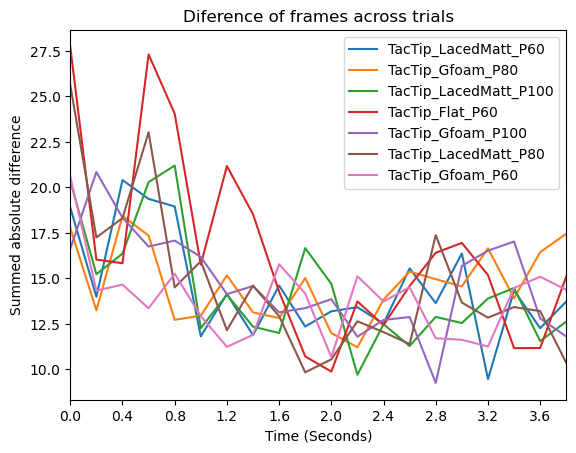

In [318]:
av=np.std(change,axis=1)
for i in range(len(change)):
    plt.plot(av[i],label=data.keys[i])

plt.legend(loc="upper right")
plt.xticks([i for i in range(0,len(change[2]),int(len(data.X[0])*0.1))], labels=[round((4/len(data.X[0]))*i,2) for i in range(0,len(change[2]),int(len(data.X[0])*0.1))])
plt.xlabel("Time (Seconds)")
plt.xlim([0,19])
plt.ylabel("Summed absolute difference")
plt.title("Diference of frames across trials")
plt.show()

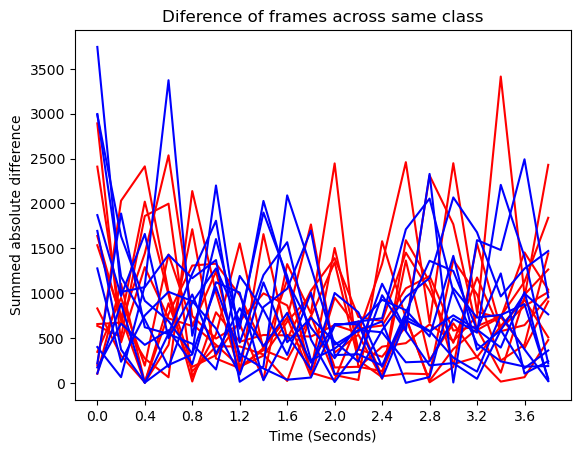

In [296]:
found=0
i=0
while found<10:
    y=data.y[i]
    if y==0:
        framesA=data.X[i][0:-2].reshape(data.X[i].shape[0], -1)
        framesB=data.X[i][1:-1].reshape(data.X[i].shape[0], -1)
        difference=np.abs(np.sum(framesA-framesB,axis=1))
        plt.plot(difference,c="r")
        found+=1
    i+=1
i=0
found=0
while found<10:
    y=data.y[i]
    if y==5:
        framesA=data.X[i][0:-2].reshape(data.X[i].shape[0], -1)
        framesB=data.X[i][1:-1].reshape(data.X[i].shape[0], -1)
        difference=np.abs(np.sum(framesA-framesB,axis=1))
        plt.plot(difference,c="b")
        found+=1
    i+=1

plt.xticks([i for i in range(0,len(change[0]),int(len(data.X[0])*0.1))], labels=[round((4/len(data.X[0]))*i,2) for i in range(0,len(change[0]),int(len(data.X[0])*0.1))])
plt.xlabel("Time (Seconds)")
plt.ylabel("Summed absolute difference")
plt.title("Diference of frames across same class")
plt.show()
    

#